In [1]:
%config Completer.use_jedi = False

## Import Modules

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout, BatchNormalization
from tensorflow.keras.datasets import cifar10
from keras.callbacks import ModelCheckpoint, EarlyStopping

from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import numpy as np

## Load Dataset - CIFAR 10

In [3]:
(train_X, train_y), (testData, testLabels) = cifar10.load_data()

In [4]:
CLASS_NAMES= ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

In [5]:
print(train_X.shape)
print(train_y.shape)
print(testData.shape)
print(testLabels.shape)

(50000, 32, 32, 3)
(50000, 1)
(10000, 32, 32, 3)
(10000, 1)


In [6]:
trainData, valData, trainLabels, valLabels = train_test_split(train_X, train_y, test_size=0.10, random_state=42)

In [7]:
print(trainData.shape)
print(trainLabels.shape)
print(valData.shape)
print(valLabels.shape)

(45000, 32, 32, 3)
(45000, 1)
(5000, 32, 32, 3)
(5000, 1)


In [8]:
train_ds = tf.data.Dataset.from_tensor_slices((trainData, trainLabels))
test_ds = tf.data.Dataset.from_tensor_slices((testData, testLabels))
val_ds = tf.data.Dataset.from_tensor_slices((valData, valLabels))

In [9]:
type(train_ds)

tensorflow.python.data.ops.dataset_ops.TensorSliceDataset

In [10]:
train_ds

<TensorSliceDataset shapes: ((32, 32, 3), (1,)), types: (tf.uint8, tf.uint8)>

Train images array shape: (4, 32, 32, 3)


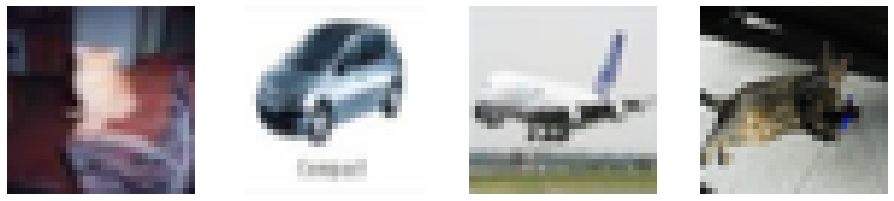

In [11]:
plt.figure(figsize=(20,20))
images = trainData[0:4]

print ("Train images array shape: {}".format(images.shape))

for i, test_image in enumerate(images, start=1):
    plt.subplot(5,5,i+1)
    plt.axis('off')
    plt.imshow(test_image, cmap=plt.get_cmap('gray'))

plt.show()

In [12]:
train_ds_size = tf.data.experimental.cardinality(train_ds).numpy()
test_ds_size = tf.data.experimental.cardinality(test_ds).numpy()
val_ds_size = tf.data.experimental.cardinality(val_ds).numpy()
print("Training data size:", train_ds_size)
print("Test data size:", test_ds_size)
print("Validation data size:", val_ds_size)

Training data size: 45000
Test data size: 10000
Validation data size: 5000


In [13]:
def process_images(image, label):
    # Normalize images to have a mean of 0 and standard deviation of 1
    image = tf.image.per_image_standardization(image)
    # Resize images from 32x32 to 277x277
    image = tf.image.resize(image, (128,128))
    return image, label

In [14]:
train_ds = (train_ds.map(process_images).shuffle(buffer_size=train_ds_size).batch(batch_size=32, drop_remainder=True))
test_ds = (test_ds.map(process_images).shuffle(buffer_size=train_ds_size).batch(batch_size=32, drop_remainder=True))
val_ds = (val_ds.map(process_images).shuffle(buffer_size=train_ds_size).batch(batch_size=32, drop_remainder=True))

## Create AlexNet Model

In [23]:
input_shape = (64,64,3)
print(input_shape)

(64, 64, 3)


In [24]:
vgg16_model = Sequential()
vgg16_model.add(Conv2D(input_shape=input_shape,filters=64,kernel_size=(3,3),padding="same", activation="relu"))
vgg16_model.add(Conv2D(filters=64,kernel_size=(3,3),padding="same", activation="relu"))
vgg16_model.add(MaxPooling2D(pool_size=(2,2),strides=(2,2)))
vgg16_model.add(Conv2D(filters=128, kernel_size=(3,3), padding="same", activation="relu"))
vgg16_model.add(Conv2D(filters=128, kernel_size=(3,3), padding="same", activation="relu"))
vgg16_model.add(MaxPooling2D(pool_size=(2,2),strides=(2,2)))
vgg16_model.add(Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"))
vgg16_model.add(Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"))
vgg16_model.add(Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"))
vgg16_model.add(MaxPooling2D(pool_size=(2,2),strides=(2,2)))
vgg16_model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
vgg16_model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
vgg16_model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
vgg16_model.add(MaxPooling2D(pool_size=(2,2),strides=(2,2)))
vgg16_model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
vgg16_model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
vgg16_model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
vgg16_model.add(MaxPooling2D(pool_size=(2,2),strides=(2,2)))

vgg16_model.add(Flatten())
vgg16_model.add(Dense(units=4096,activation="relu"))
vgg16_model.add(Dense(units=4096,activation="relu"))
vgg16_model.add(Dense(units=2, activation="softmax"))

In [25]:
vgg16_model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_28 (Conv2D)           (None, 64, 64, 64)        1792      
_________________________________________________________________
conv2d_29 (Conv2D)           (None, 64, 64, 64)        36928     
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 32, 32, 64)        0         
_________________________________________________________________
conv2d_30 (Conv2D)           (None, 32, 32, 128)       73856     
_________________________________________________________________
conv2d_31 (Conv2D)           (None, 32, 32, 128)       147584    
_________________________________________________________________
max_pooling2d_11 (MaxPooling (None, 16, 16, 128)       0         
_________________________________________________________________
conv2d_32 (Conv2D)           (None, 16, 16, 256)      

In [26]:
vgg16_model.compile(loss=keras.losses.sparse_categorical_crossentropy, optimizer=keras.optimizers.Adam(), metrics=['accuracy'])

In [27]:
EPOCHS = 50

In [ ]:
checkpoint = ModelCheckpoint("vgg16_1.h5", monitor='val_acc', verbose=1, save_best_only=True, save_weights_only=False, mode='auto', period=1)

early = EarlyStopping(monitor='val_acc', min_delta=0, patience=20, verbose=1, mode='auto')

In [ ]:
history = vgg16_model.fit(train_ds, epochs=EPOCHS, validation_data=val_ds)

hist = model.fit_generator(steps_per_epoch=100, generator=trainData, validation_data=valData, validation_steps=10,epochs=100,callbacks=[checkpoint,early])

In [25]:
print("DONE")

DONE
